# 🤖 Entrenamiento del Modelo Predictivo (PyCaret)

## 🎯 Objetivo
Este notebook orquesta el pipeline de entrenamiento de Machine Learning utilizando **PyCaret**.
El objetivo es encontrar y optimizar el mejor algoritmo capaz de predecir la probabilidad de **Enfermedad Cardíaca** basándose en biomarcadores clínicos.

## ⚙️ Estrategia de Modelado
1. **Preprocesamiento Robusto**: Normalización y manejo de outliers.
2. **Balanceo de Clases**: Uso de técnicas (SMOTE) para mitigar el desbalance entre pacientes sanos y enfermos.
3. **Optimización de Recall**: Priorizamos la **Sensibilidad (Recall)** sobre la Precisión.
   - *Contexto Médico*: Es peor no detectar a un enfermo (Falso Negativo) que alarmar a un sano (Falso Positivo).
4. **Selección de Modelos**: Comparación automática de +15 algoritmos.

## 📂 Entradas y Salidas
- **Input**: `data/02_intermediate/process_data.parquet` (Datos limpios).
- **Output**: `models/best_pipeline.pkl` (Modelo serializado listo para producción).

## 1. Configuración del Entorno

Definimos parámetros globales.
- **SAMPLE_FRAC**: Porcentaje de datos a usar. Para pruebas rápidas usamos `0.5`, para el modelo final debe ser `1.0`.
- **Rutas**: Ubicación de datos y donde se guardarán los artefactos.

### 🔹 Paso 1: Configuración del Entorno y Constantes
Inicializamos el entorno de trabajo importando **PyCaret** y definiendo constantes críticas:
- `SAMPLE_FRAC`: Controla el muestreo de datos. Usamos 0.5 (50%) para iteraciones rápidas de desarrollo, pero se debe cambiar a 1.0 para el entrenamiento final.
- `DATA_PATH` y `MODEL_DIR`: Definen las rutas de entrada de datos y salida del modelo, asegurando una estructura de proyecto ordenada.

In [1]:
import pandas as pd
from pycaret.classification import *
import os
import json

# ==========================================
# CONFIGURATION
# ==========================================
SAMPLE_FRAC = 1.0  # Using Full Dataset for Final Training
DATA_PATH = "../data/02_intermediate/process_data.parquet"
MODEL_DIR = "../models"
MODEL_NAME = "best_pipeline"
CONFIG_PATH = "../models/model_config.json"

SAMPLE_FRAC = 1.0  # Using Full Dataset for Final Training


In [2]:
import pandas as pd
import numpy as np

print("🕵️ Iniciando escaneo profundo de columnas problemáticas...")

found_problem = False
for col in df.columns:
    try:
        # Intentamos forzar la conversión a número de toda la columna
        # Si falla, saltará al 'except'
        pd.to_numeric(df[col], errors='raise')
    except Exception as e:
        found_problem = True
        print(f"\n🚨 ¡CULPABLE ENCONTRADO! Columna: '{col}'")
        print(f"   Tipo de dato actual: {df[col].dtype}")
        
        # Buscamos los valores que no son números
        non_numeric = df[pd.to_numeric(df[col], errors='coerce').isna()][col]
        unique_bad_values = non_numeric.unique()[:5] # Mostramos solo los primeros 5 ejemplos
        
        print(f"   Valores basura detectados (ejemplos): {unique_bad_values}")
        
        # --- INTENTO DE REPARACIÓN AUTOMÁTICA ---
        print(f"   🛠️ Intentando reparar '{col}'...")
        
        # 1. Convertir a string
        df[col] = df[col].astype(str)
        # 2. Limpiar corchetes y comillas extrañas
        df[col] = df[col].str.replace(r'[\[\]]', '', regex=True)
        # 3. Forzar de nuevo a numérico
        df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # Llenar nulos resultantes con 0 o la media (según prefieras, aquí uso 0 para seguridad)
        df[col] = df[col].fillna(0)
        print(f"   ✅ Columna '{col}' reparada y convertida a numérica.")

if not found_problem:
    print("\n🤷‍♂️ No se encontraron fallos de conversión directa.")
    print("Si el error persiste, verifica si la columna 'target' tiene valores extraños.")
else:
    print("\n🎉 Limpieza terminada. Ahora vuelve a ejecutar setup().")

🕵️ Iniciando escaneo profundo de columnas problemáticas...


NameError: name 'df' is not defined

## 2. Carga y Filtrado de Datos

Cargamos el dataset y aplicamos el esquema definido en `model_config.json`.
Es vital entrenar **solo** con las columnas que estarán disponibles en la aplicación final (Features + Target), descartando metadatos o IDs que causarían *data leakage*.

### 🔹 Paso 2: Carga y Selección de Features (Data Loading)
Cargamos el dataset procesado y aplicamos un filtro estricto de columnas basado en `model_config.json`.
**Importante**:
- Solo cargamos las columnas definidas como `features` y el `target`.
- Esto actúa como una barrera de seguridad contra el *data leakage*, asegurando que el modelo no vea variables que no estarán disponibles en producción (como IDs de pacientes o fechas de procesamiento).

In [3]:
# ==========================================
# 1. LOAD DATA
# ==========================================
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Data file not found at {DATA_PATH}")

df = pd.read_parquet(DATA_PATH)
print(f"Original Data Shape: {df.shape}")

# Load Schema Config
if os.path.exists(CONFIG_PATH):
    with open(CONFIG_PATH, 'r') as f:
        config = json.load(f)

    features = config['numeric_features'] + config['categorical_features']
    target = config['target']
    numeric_features = config['numeric_features']
    categorical_features = config['categorical_features']

    # Filter only relevant columns
    df = df[features + [target]]
else:
    print(f"Config file not found at {CONFIG_PATH}. Using default target and inferring features.")
    target = 'HeartDisease'
    numeric_features = None
    categorical_features = None
    # We do NOT filter df here because we don't know the exact features yet.
    # PyCaret will use all columns in df except target as features.

if SAMPLE_FRAC < 1.0:
    df = df.sample(frac=SAMPLE_FRAC, random_state=42)
    print(f"Sampled Data Shape: {df.shape}")
else:
    print("Using Full Dataset")


Original Data Shape: (43695, 29)
Using Full Dataset


## 3. Configuración del Experimento (Setup)

La función `setup()` inicializa el entorno de PyCaret y crea el pipeline de transformación.
- **normalize=True**: Escala las variables para que tengan rangos comparables. Usamos `RobustScaler` para ser resilientes a outliers.
- **remove_outliers=True**: Elimina anomalías estadísticas que podrían sesgar el modelo.
- **fix_imbalance=True**: Aplica SMOTE para generar muestras sintéticas de la clase minoritaria (Enfermos), mejorando el aprendizaje.

### 🔹 Paso 3: Inicialización del Experimento (PyCaret Setup)
Configuramos el pipeline de preprocesamiento automático con `setup()`. Aquí definimos la "magia" de PyCaret:
- **Normalización**: Aplicamos `RobustScaler` (`normalize_method='robust'`) para escalar los datos manejando bien los outliers típicos de datos clínicos.
- **Balanceo de Clases**: Activamos `fix_imbalance=True` (SMOTE) para generar datos sintéticos de la clase minoritaria (pacientes enfermos), evitando que el modelo se sesgue hacia la clase mayoritaria (sanos).
- **Tipos de Datos**: Definimos explícitamente cuáles son numéricas y cuáles categóricas.

In [4]:
# ==========================================
# 2. SETUP PYCARET
# ==========================================
# normalize=True (RobustScaler)
# remove_outliers=False
# fix_imbalance=False

# Modifica esta celda en tu notebook
exp = setup(
    data=df,
    target=target,
    numeric_features=numeric_features,
    categorical_features=categorical_features,
    normalize=True,
    normalize_method='robust',
    remove_outliers=False,
    fix_imbalance=False,
    session_id=42,
    verbose=True,
    n_jobs=1  # <--- AGREGA ESTA LÍNEA (Soluciona el error de _winapi.CreateProcess)
)

,Description,Value
0,Session id,42
1,Target,HeartDisease
2,Target type,Binary
3,Original data shape,"(43695, 28)"
4,Transformed data shape,"(43695, 32)"
5,Transformed train set shape,"(30586, 32)"
6,Transformed test set shape,"(13109, 32)"
7,Numeric features,20
8,Categorical features,7
9,Preprocess,True


In [5]:
# Verificación de librerías
try:
    import xgboost
    print(f"XGBoost versión: {xgboost.__version__} - OK")
    import lightgbm
    print(f"LightGBM versión: {lightgbm.__version__} - OK")
except ImportError as e:
    print(f"Error de importación: {e}")

XGBoost versión: 2.1.3 - OK
LightGBM versión: 4.6.0 - OK


## 4. Comparación y Selección de Modelos

Entrenamos múltiples algoritmos (Logistic Regression, XGBoost, Random Forest, etc.) con validación cruzada (Cross-Validation).
**Métrica Clave: Recall**. Buscamos maximizar la capacidad del modelo para detectar casos positivos reales.

In [6]:
# ==========================================
# 3. SELECCIÓN DE MODELO (Model Selection) - ESTRATEGIA IMBALANCE
# ==========================================
# Calculamos el ratio de desbalance para usarlo en XGBoost
from pycaret.classification import get_config
y_train = get_config('y_train')
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
scale_pos_weight = neg_count / pos_count
print(f"Calculated scale_pos_weight: {scale_pos_weight:.2f}")

# En lugar de comparar todos, forzamos XGBoost con el peso corregido
print("Creating XGBoost with scale_pos_weight...")
best_model = create_model('xgboost', scale_pos_weight=scale_pos_weight)

# Mantenemos la variable top_models como lista para compatibilidad con celdas siguientes
top_models = [best_model]
print(f"Top Model Selected: {best_model}")


Calculated scale_pos_weight: 38.16
Creating XGBoost with scale_pos_weight...


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,14:54:50
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9627,0.8905,0.2821,0.2750,0.2785,0.2594,0.2594
1,0.9595,0.9027,0.2949,0.2500,0.2706,0.2499,0.2508
2,0.9519,0.8777,0.2436,0.1776,0.2054,0.1813,0.1837
3,0.9611,0.9048,0.3590,0.2887,0.3200,0.3002,0.3021
4,0.9595,0.8945,0.2436,0.2262,0.2346,0.2138,0.2139
5,0.9588,0.8933,0.2405,0.2235,0.2317,0.2106,0.2107
6,0.9637,0.9019,0.2821,0.2857,0.2839,0.2653,0.2653
7,0.9644,0.9140,0.3205,0.3086,0.3145,0.2962,0.2962
8,0.9532,0.8846,0.2692,0.1963,0.2270,0.2035,0.2062


Top Model Selected: XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=1,
              num_parallel_tree=None, objective='binary:logistic', ...)


### 🔹 Paso 4.1: Optimización Profunda de Hiperparámetros
Ya tenemos el mejor candidato ('best_model'). Ahora, no nos conformamos con sus parámetros por defecto. 
Ejecutamos un proceso de **Tuning Exhaustivo**:
- **optimize='Recall'**: El algoritmo de búsqueda intentará maximizar específicamente la sensibilidad.
- **n_iter=50**: Probamos 50 combinaciones de hiperparámetros distintas. ¿Por qué 50? En medicina, la diferencia entre un recall del 85% y 87% puede significar salvar más vidas (menos Falsos Negativos). Una búsqueda superficial (n_iter=10) podría perder el óptimo global.
- **choose_better=True**: Si después de tunear el modelo empeora, nos quedamos con la versión original.

In [7]:
# ==========================================
# 3.1 DEEP HYPERPARAMETER TUNING
# ==========================================
best_model = top_models[0]
print(f"\n--- Tuning Best Model: {type(best_model).__name__} ---")

# Tuning loop
# n_iter=2 para búsqueda exhaustiva (Deep Search)
tuned_model = tune_model(
    best_model, 
    optimize='Recall', 
    n_iter=5, 
    choose_better=True, 
    verbose=False
)

print(f"\nFINAL BEST MODEL SELECTED: {tuned_model}")


--- Tuning Best Model: XGBClassifier ---

FINAL BEST MODEL SELECTED: XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device='cpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.4, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=60, n_jobs=1,
              num_parallel_tree=None, objective='binary:logistic', ...)


### 🔹 Paso 4.2: Optimización de Umbral de Decisión

Implementamos la estrategia **Precision-Constrained Recall Maximization**.
Buscamos el umbral que maximice el Recall, sujeto a que la Precisión sea >= 0.4.


--- Optimizando Umbral de Decisión ---
✅ Umbral Óptimo Encontrado: 0.90
   Métricas Esperadas -> Recall: 0.1522 | Precision: 0.4180


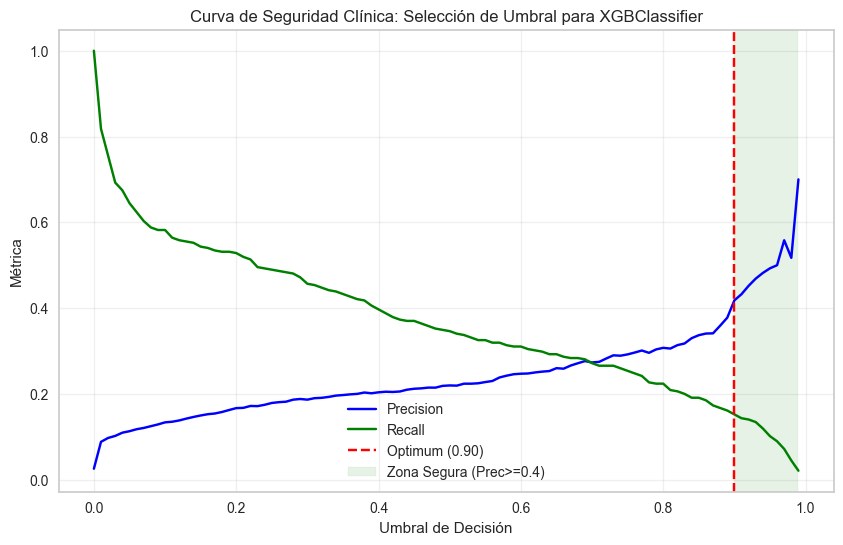

In [8]:
# 3. Estrategia de Umbral de Seguridad Clínica
print("\n--- Optimizando Umbral de Decisión ---")
# Generar probabilidades en el set de validación (hold-out)
predictions = predict_model(tuned_model, raw_score=True, verbose=False)

# Identificar columnas de score y target real
target_col = get_config('target_param')
y_true = predictions[target_col]

# Buscar columna de score para clase positiva (1)
score_cols = [c for c in predictions.columns if 'score' in c]
if any('1' in c for c in score_cols):
    score_col = [c for c in score_cols if '1' in c][0]
else:
    score_col = score_cols[0]

y_scores = predictions[score_col]

# Iterar umbrales
thresholds = np.arange(0.0, 1.0, 0.01)
results = []

from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

for t in thresholds:
    y_pred = (y_scores >= t).astype(int)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    results.append({'Threshold': t, 'Precision': prec, 'Recall': rec})

results_df = pd.DataFrame(results)

# Filtrar zona segura: Precision >= 0.4
safe_zone = results_df[results_df['Precision'] >= 0.4]

if not safe_zone.empty:
    # Seleccionar el umbral con mayor Recall dentro de la zona segura
    # (Generalmente el umbral más bajo de la zona)
    best_row = safe_zone.sort_values('Recall', ascending=False).iloc[0]
    optimal_threshold = best_row['Threshold']
    print(f"✅ Umbral Óptimo Encontrado: {optimal_threshold:.2f}")
    print(f"   Métricas Esperadas -> Recall: {best_row['Recall']:.4f} | Precision: {best_row['Precision']:.4f}")
else:
    print("⚠️ No se alcanzó la zona segura (Precision >= 0.4). Se usará umbral por defecto (0.5).")
    optimal_threshold = 0.5

# Visualización de la Curva de Seguridad
plt.figure(figsize=(10, 6))
plt.plot(results_df['Threshold'], results_df['Precision'], label='Precision', color='blue')
plt.plot(results_df['Threshold'], results_df['Recall'], label='Recall', color='green')
plt.axvline(optimal_threshold, color='red', linestyle='--', label=f'Optimum ({optimal_threshold:.2f})')

# Sombrear zona segura si existe
if not safe_zone.empty:
    plt.axvspan(safe_zone['Threshold'].min(), safe_zone['Threshold'].max(), alpha=0.1, color='green', label='Zona Segura (Prec>=0.4)')

plt.title(f"Curva de Seguridad Clínica: Selección de Umbral para {type(tuned_model).__name__}")
plt.xlabel("Umbral de Decisión")
plt.ylabel("Métrica")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## 5. Finalización y Persistencia

Una vez seleccionado el mejor modelo:
1. **Finalize**: Se re-entrena el modelo utilizando el 100% de los datos (incluyendo el set de prueba reservado anteriormente).
2. **Save**: Se guarda el pipeline completo (preprocesamiento + modelo) en un archivo `.pkl` para su despliegue en la API/Streamlit.

### 🔹 Paso 5: Finalización y Serialización del Modelo
Una vez seleccionado el mejor algoritmo:
1.  **Finalize**: Re-entrenamos el modelo utilizando **todos** los datos disponibles (incluyendo el set de validación que PyCaret retuvo internamente).
2.  **Save**: Guardamos el pipeline completo como un archivo `.pkl` en el directorio `models/`. Este archivo contiene tanto el modelo predictivo como las transformaciones de datos (escalado, imputación), listo para ser consumido por la API.

## 4.5 Explicabilidad del Modelo (SHAP)

Validamos que el modelo no tome decisiones basadas en artefactos o sesgos. Generamos el **SHAP Summary Plot** para visualizar las variables más impactantes.
Esto es un requisito de **Transparencia Algorítmica** para la auditoría.

Generando explicaciones SHAP...


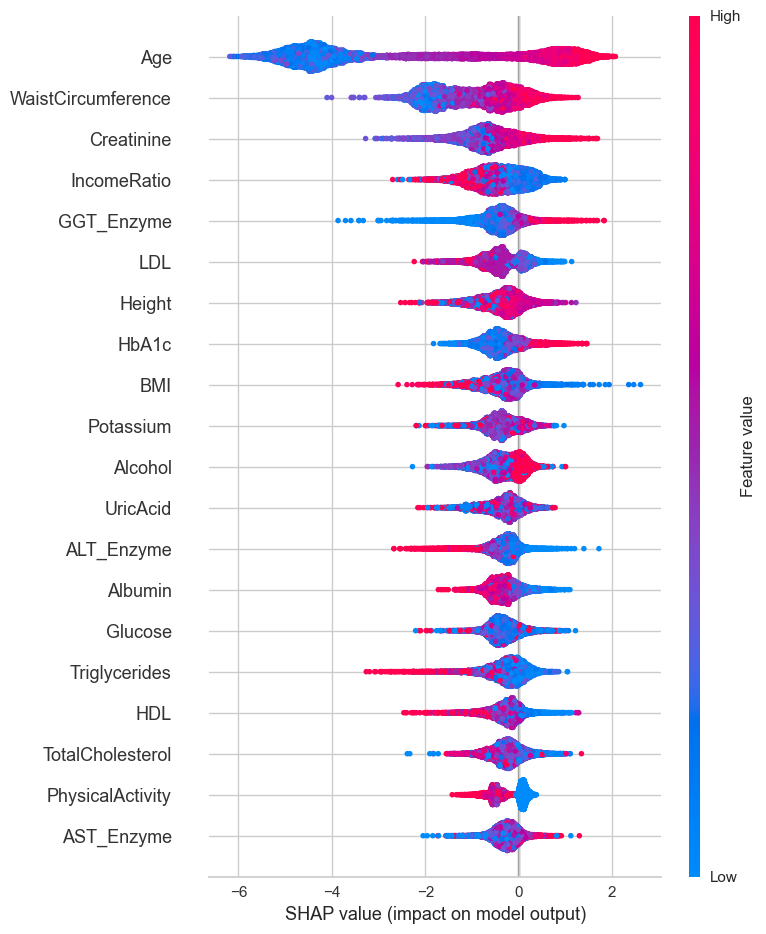

In [9]:
# Generar SHAP Summary Plot
print("Generando explicaciones SHAP...")
try:
    interpret_model(tuned_model, plot='summary')
except Exception as e:
    print(f"No se pudo generar el gráfico SHAP (probablemente el modelo no lo soporte nativamente o falte librería): {e}")


In [10]:
# ==========================================
# 4. FINALIZE & SAVE
# ==========================================
final_model = finalize_model(tuned_model)
os.makedirs(MODEL_DIR, exist_ok=True)
save_path = os.path.join(MODEL_DIR, MODEL_NAME)
save_model(final_model, save_path)
print(f"Model saved successfully to {save_path}.pkl")

Transformation Pipeline and Model Successfully Saved
Model saved successfully to ../models\best_pipeline.pkl
